__________________________________________________________________________________
                             |Predicting BTC with LSTM|
                                   |Stacked LSTM|
                                   
Gabriel Lyra      - glgs2  
Guilherme Melo    - gacm  
Henrique Mariz    - ham2  
Matheus Belfort   - mbmt  
Matheus Lima      - mlbp  
__________________________________________________________________________________

Importando as bibliotecas necessárias

In [76]:
import warnings
warnings.filterwarnings('ignore')

import io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

%matplotlib inline

Carregando dataset

In [77]:
file = 'btc.csv'
btc = pd.read_csv(file)
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


Removendo colunas que não devem ser utilizadas no treinamento

In [78]:
btc = btc.drop(['Date', 'Symbol'], axis=1)

Separando entrada e saída

In [79]:
features = btc['Close']
outcome = btc.drop(['Close'], axis=1)

In [80]:
outcome

,Open,High,Low,Volume From,Volume To
0,7459.11,7640.46,7380.00,2722.80000,2.042265e+07
1,7584.15,7661.85,7326.94,8491.93000,6.342069e+07
2,7505.00,7734.99,7269.00,11033.72000,8.293137e+07
3,7987.70,8030.00,7433.19,14905.99000,1.148104e+08
4,8393.44,8400.00,7950.00,6589.43000,5.389753e+07
...,...,...,...,...,...
1268,377.10,377.10,377.10,0.00000,0.000000e+00
1269,378.00,378.00,377.10,0.01000,3.770000e+00
1270,378.00,378.00,377.01,0.54660,2.065200e+02
1271,370.00,378.00,370.00,15.01000,5.675070e+03


Invertendo dados

In [81]:
features = pd.DataFrame(features)
features_flipped = features["Close"].values[::-1]
features_flipped = pd.DataFrame(features_flipped)
features_flipped

,0
0,370.00
1,378.00
2,378.00
3,377.10
4,377.10
...,...
1268,7987.70
1269,7505.00
1270,7584.15
1271,7459.11


In [82]:
outcome_flipped = outcome.values[::-1]
outcome_flipped = pd.DataFrame(outcome_flipped)
outcome_flipped

,0,1,2,3,4
0,300.00,370.00,300.00,0.05656,1.953000e+01
1,370.00,378.00,370.00,15.01000,5.675070e+03
2,378.00,378.00,377.01,0.54660,2.065200e+02
3,378.00,378.00,377.10,0.01000,3.770000e+00
4,377.10,377.10,377.10,0.00000,0.000000e+00
...,...,...,...,...,...
1268,8393.44,8400.00,7950.00,6589.43000,5.389753e+07
1269,7987.70,8030.00,7433.19,14905.99000,1.148104e+08
1270,7505.00,7734.99,7269.00,11033.72000,8.293137e+07
1271,7584.15,7661.85,7326.94,8491.93000,6.342069e+07


Grafico do dataset completo

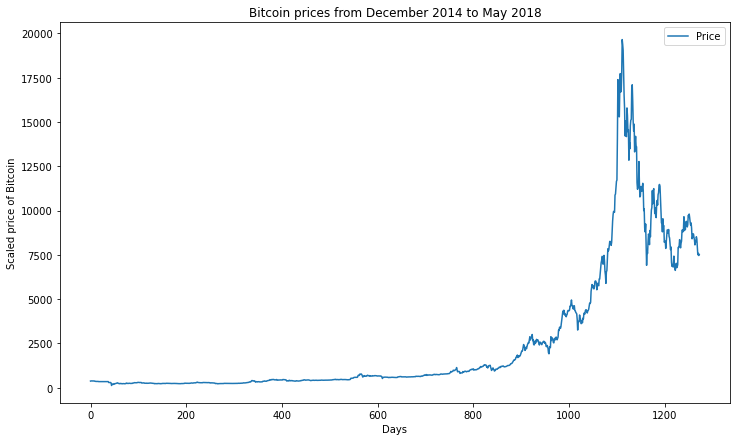

In [83]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(features_flipped, label='Price')
plt.legend()
plt.show()

Separando partes do dataset

In [84]:
close_price = np.array(features_flipped).reshape(-1,1)

Testando com o StantardScaler

In [10]:
standard_scalar = StandardScaler()

close_priceSC = standard_scalar.fit_transform(np.array(close_price).reshape(-1,1))

In [11]:
stepsize = 8

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1265, 8) (1265,)


In [12]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [13]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8)
y_train size: (1018,)
X_test size: (247, 8)
y_test size: (247,)


In [14]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8, 1)
y_train size: (1018,)
X_test size: (247, 8, 1)
y_test size: (247,)


In [15]:
model=Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 31s 10ms/step - loss: 0.1216
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0048
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0012
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 9.9704e-04
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 8/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 9/100
32/32 [==============================] - 0s 11ms/step - loss: 9.5854e-04
Epoch 10/100
32/32 [==============================] - ETA: 0s - loss: 9.6839e-0 - 0s 10ms/step - loss: 9.7938e-04
Epoch 11/100
32/32 [==============================] - 0s 9ms/step - loss: 9.9514e-04s - loss: 0
Epoch 12/100
32/32 [==============================] -

____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 8  
ativação = relu  
otimização = adam  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

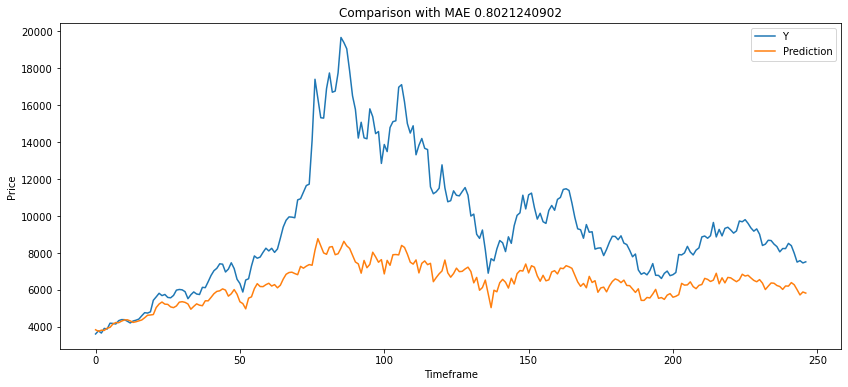

In [19]:
plt.figure(figsize=(14,6))
plt.plot(standard_scalar.inverse_transform(y_test.reshape(-1,1)))
plt.plot(standard_scalar.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Testando com o MinMaxScaler

In [85]:
close_price = np.array(features_flipped).reshape(-1,1)

In [86]:
scaler=MinMaxScaler(feature_range=(0,1))

close_priceSC = scaler.fit_transform(np.array(close_price).reshape(-1,1))

In [87]:
stepsize = 8

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1265, 8) (1265,)


In [32]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [33]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8)
y_train size: (1018,)
X_test size: (247, 8)
y_test size: (247,)


In [34]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8, 1)
y_train size: (1018,)
X_test size: (247, 8, 1)
y_test size: (247,)


In [35]:
model=Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 5s 8ms/step - loss: 0.0017
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 1.2633e-04
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 3.9692e-05
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 3.7817e-05
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 5.0716e-05
Epoch 6/100
32/32 [==============================] - 0s 8ms/step - loss: 3.7113e-05
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 4.7966e-05
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 6.0438e-05
Epoch 9/100
32/32 [==============================] - 0s 8ms/step - loss: 4.8871e-05
Epoch 10/100
32/32 [==============================] - 0s 10ms/step - loss: 4.2767e-05
Epoch 11/100
32/32 [==============================] - ETA: 0s - loss: 5.1630e-05- ETA: 0s - loss: 5.1696e - 0s 9ms/step - loss: 5.1585e-05
Epoch 12/100
32/32 [===

____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 8  
ativação = relu  
otimização = adam  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [37]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [38]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

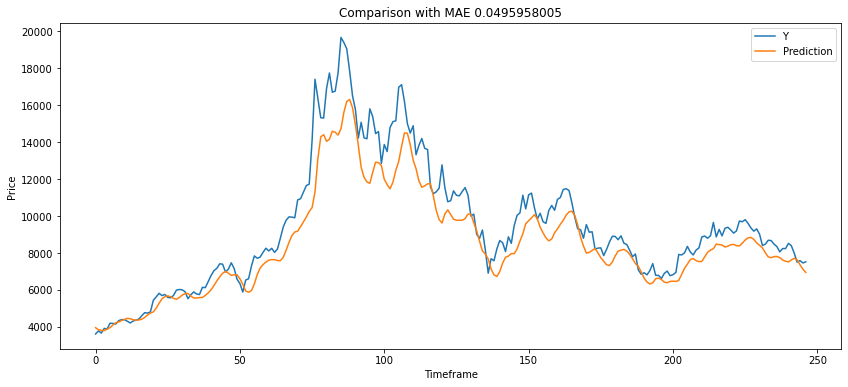

In [39]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Teste com outra função de ativação (tahn)

In [40]:
stepsize = 8

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1265, 8) (1265,)


In [41]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [42]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8)
y_train size: (1018,)
X_test size: (247, 8)
y_test size: (247,)


In [43]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8, 1)
y_train size: (1018,)
X_test size: (247, 8, 1)
y_test size: (247,)


In [44]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [45]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 6s 9ms/step - loss: 0.0014
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 9.6919e-05
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 5.8326e-05
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 4.9798e-05
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 5.3614e-05
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 4.7130e-05
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 5.8180e-05
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 4.2344e-05
Epoch 9/100
32/32 [==============================] - 0s 8ms/step - loss: 4.3464e-05
Epoch 10/100
32/32 [==============================] - 0s 10ms/step - loss: 4.4888e-05
Epoch 11/100
32/32 [==============================] - 0s 10ms/step - loss: 5.9994e-05
Epoch 12/100
32/32 [==============================] - 0s 9ms/step - loss:

32/32 [==============================] - 0s 9ms/step - loss: 1.6472e-05
Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 1.1674e-05
Epoch 98/100
32/32 [==============================] - ETA: 0s - loss: 1.4458e-0 - 0s 10ms/step - loss: 1.4569e-05
Epoch 99/100
32/32 [==============================] - 0s 9ms/step - loss: 1.8838e-05
Epoch 100/100
32/32 [==============================] - 0s 8ms/step - loss: 1.3358e-05


____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 8  
ativação = tahn  
otimização = adam  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [46]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [47]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

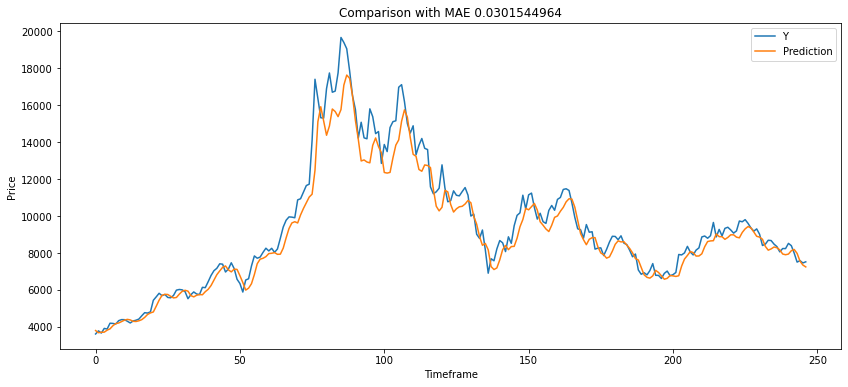

In [48]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [49]:
stepsize = 64

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1209, 64) (1209,)


In [50]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [51]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 64)
y_train size: (1018,)
X_test size: (191, 64)
y_test size: (191,)


In [52]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 64, 1)
y_train size: (1018,)
X_test size: (191, 64, 1)
y_test size: (191,)


In [53]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [54]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 7s 55ms/step - loss: 0.0029
Epoch 2/100
32/32 [==============================] - 2s 48ms/step - loss: 1.2349e-04
Epoch 3/100
32/32 [==============================] - 1s 46ms/step - loss: 1.2332e-04
Epoch 4/100
32/32 [==============================] - 2s 53ms/step - loss: 2.4140e-04
Epoch 5/100
32/32 [==============================] - 2s 48ms/step - loss: 1.6344e-04: 0s - loss: 1.6369e
Epoch 6/100
32/32 [==============================] - 2s 59ms/step - loss: 1.7944e-04
Epoch 7/100
32/32 [==============================] - 2s 50ms/step - loss: 1.2978e-04
Epoch 8/100
32/32 [==============================] - 2s 61ms/step - loss: 1.0872e-04
Epoch 9/100
32/32 [==============================] - 2s 66ms/step - loss: 1.4516e-04
Epoch 10/100
32/32 [==============================] - 2s 61ms/step - loss: 1.2012e-04
Epoch 11/100
32/32 [==============================] - 2s 58ms/step - loss: 1.0793e-04
Epoch 12/100
32/32 [===========================

____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 64  
ativação = tahn  
otimização = adam  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [56]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

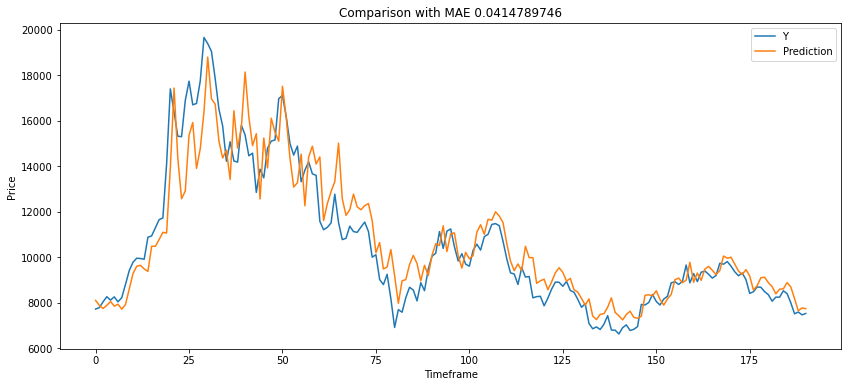

In [57]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Teste com o otimizador sgd

In [58]:
stepsize = 8

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1265, 8) (1265,)


In [59]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [60]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8)
y_train size: (1018,)
X_test size: (247, 8)
y_test size: (247,)


In [61]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8, 1)
y_train size: (1018,)
X_test size: (247, 8, 1)
y_test size: (247,)


In [62]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='sgd')

In [63]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 5s 8ms/step - loss: 0.0030
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 6/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0020
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 8/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 9/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 10/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 11/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 12/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 13/100
32/32 [================

____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 8  
ativação = tahn  
otimização = sgd  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [64]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [65]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

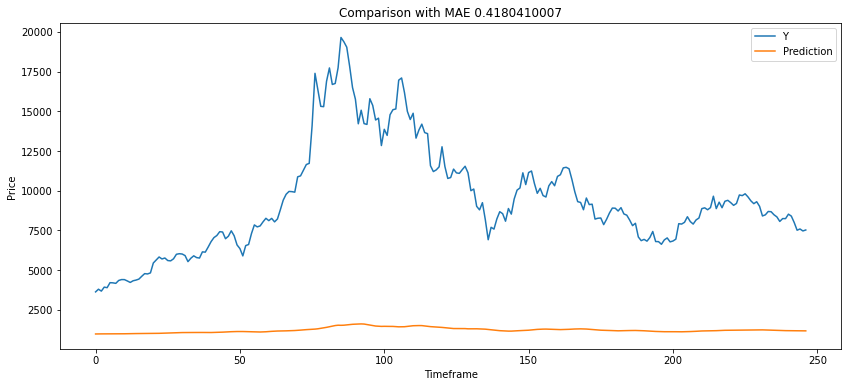

In [66]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Teste com batch_size maior

In [67]:
stepsize = 8

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1265, 8) (1265,)


In [68]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [69]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8)
y_train size: (1018,)
X_test size: (247, 8)
y_test size: (247,)


In [70]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8, 1)
y_train size: (1018,)
X_test size: (247, 8, 1)
y_test size: (247,)


In [71]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [72]:
model.fit(X_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
8/8 [==============================] - 5s 16ms/step - loss: 0.0029
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 5.2866e-04
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 2.2931e-04
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 8.2363e-05
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 8.6396e-05
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 4.5499e-05
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 5.7092e-05
Epoch 9/100
8/8 [==============================] - ETA: 0s - loss: 4.6377e-0 - 0s 23ms/step - loss: 4.5291e-05
Epoch 10/100
8/8 [==============================] - 0s 17ms/step - loss: 3.9219e-05
Epoch 11/100
8/8 [==============================] - 0s 22ms/step - loss: 3.8260e-05
Epoch 12/100
8/8 [==============================] - 0s 16ms/step 

8/8 [==============================] - 0s 14ms/step - loss: 3.4351e-05
Epoch 99/100
8/8 [==============================] - 0s 14ms/step - loss: 3.6503e-05
Epoch 100/100
8/8 [==============================] - 0s 14ms/step - loss: 3.0023e-05


____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 8  
ativação = tahn  
otimização = adam  
batchsize = 128  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [73]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [74]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

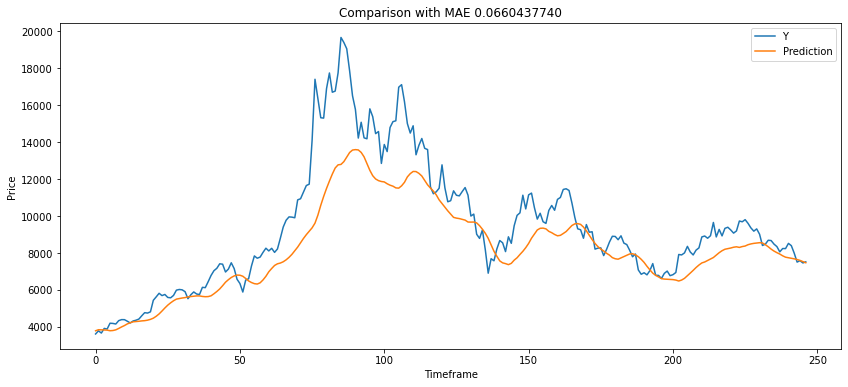

In [75]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Teste com mais Stacks

In [88]:
stepsize = 8

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1265, 8) (1265,)


In [89]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [90]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8)
y_train size: (1018,)
X_test size: (247, 8)
y_test size: (247,)


In [91]:
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 8, 1)
y_train size: (1018,)
X_test size: (247, 8, 1)
y_test size: (247,)


In [92]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [93]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 7s 11ms/step - loss: 0.0019
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 1.1614e-04
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 4.7881e-05
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 4.3632e-05
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 4.7914e-05
Epoch 6/100
32/32 [==============================] - 0s 11ms/step - loss: 5.6747e-05
Epoch 7/100
32/32 [==============================] - 0s 11ms/step - loss: 6.5345e-05
Epoch 8/100
32/32 [==============================] - 0s 11ms/step - loss: 6.4573e-05
Epoch 9/100
32/32 [==============================] - 0s 11ms/step - loss: 4.4955e-05
Epoch 10/100
32/32 [==============================] - 0s 11ms/step - loss: 5.1602e-05
Epoch 11/100
32/32 [==============================] - 0s 11ms/step - loss: 5.0833e-05
Epoch 12/100
32/32 [==============================] - 0s 12ms/step 

32/32 [==============================] - 0s 11ms/step - loss: 2.3372e-05
Epoch 95/100
32/32 [==============================] - 0s 10ms/step - loss: 2.2824e-05
Epoch 96/100
32/32 [==============================] - 0s 11ms/step - loss: 2.0547e-05
Epoch 97/100
32/32 [==============================] - 0s 11ms/step - loss: 1.6984e-05
Epoch 98/100
32/32 [==============================] - 0s 11ms/step - loss: 2.6022e-05
Epoch 99/100
32/32 [==============================] - 0s 11ms/step - loss: 2.3061e-05
Epoch 100/100
32/32 [==============================] - 0s 11ms/step - loss: 2.1864e-05


____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 8  
ativação = tahn  
otimização = adam  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [94]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [95]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

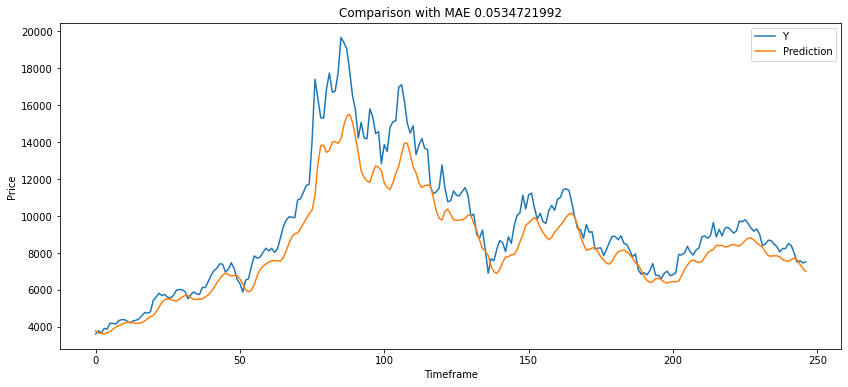

In [96]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")